In [1]:
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import os
from env import host, user, password
import warnings
warnings.filterwarnings("ignore")

# Acquire:

### Project Breakdown:

1. Data in CSV needed to be formatted.  I chose to formatt in excel.   


2. In excel only 8 of 248 daily food logs were recorded.  With 97% of data missing I decided to drop the food log columns.'Calories_in' was also dropped for the same reason.   


3. There are 22 missing rows of data at the end of the dataframe.  The last activity entries were 12/6.  Because no activity entries have been missing in the dataset I chose to delete the missing values after 12/6.    


4. This leaves me with a df that is 10 colums by 225 rows (or 225 days worth of data)
   - 1 day = 1 row

In [2]:
df = pd.read_csv('time_series_project.csv')
df.head()

,date,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
0,4/26/18,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
1,4/27/18,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2,4/28/18,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
3,4/29/18,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
4,4/30/18,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                225 non-null    object 
 1   calories_burned     225 non-null    float64
 2   steps               225 non-null    float64
 3   distance            225 non-null    float64
 4   floors              225 non-null    float64
 5   mins_sedentary      225 non-null    float64
 6   mins_light_active   225 non-null    float64
 7   mins_fairly_active  225 non-null    float64
 8   mins_very_active    225 non-null    float64
 9   activity_calories   225 non-null    float64
dtypes: float64(9), object(1)
memory usage: 19.4+ KB


# Prepare:

### Step #1. Convert to Datetime and Reset Index

In [4]:
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


### Step #2. Create Day of Week, Month, and Year Columns

In [5]:
### Step #2. Create Day of Week, Month, and Year Columns
df['Year'] = df.index.year
df['Month'] = df.index.month
df['weekday'] = df.index.day_name()

### #3. Change data types of created colums to object and category

In [6]:
  # Change dtypes of numeric columns to object and category
df = (df.astype({'Year': 'category', 
                'Month': 'category', 
                'weekday': 'category'}))
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories,Year,Month,weekday
date,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,2018.0,4.0,Thursday
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,2018.0,4.0,Friday
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,2018.0,4.0,Saturday
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,2018.0,4.0,Sunday
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,2018.0,4.0,Monday


### #4. Descrbe (Sanity Check)

In [7]:
df.describe()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,3401.911111,8536.186667,4.046800,12.591111,809.520000,188.235556,14.920000,33.871111,1484.546667
std,632.426578,5255.746608,2.506253,25.844174,243.232639,75.170001,15.363535,37.195986,747.795790
min,799.000000,0.000000,0.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000
25%,3069.000000,4714.000000,2.220000,2.000000,654.000000,158.000000,3.000000,2.000000,1062.000000
50%,3385.000000,7806.000000,3.680000,7.000000,750.000000,203.000000,11.000000,15.000000,1481.000000
75%,3765.000000,12380.000000,5.900000,13.000000,877.000000,236.000000,21.000000,63.000000,1962.000000
max,5199.000000,25512.000000,12.000000,195.000000,1440.000000,349.000000,78.000000,154.000000,3596.000000


# Explore:

Goals:
1. Find Trends
2. Find Seasonality

### Step #1. Split Data (Human Based)

- Target Variable = calories_burned

In [8]:
df.Month.value_counts().sort_values()

4.0      5
12.0     6
11.0    30
9.0     30
6.0     30
10.0    31
8.0     31
7.0     31
5.0     31
Name: Month, dtype: int64

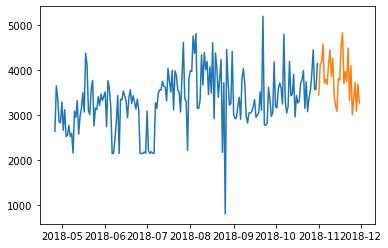

In [9]:
train = df.loc[:'2018-10'] # includes October
test = df.loc['2018-11']

plt.plot(train.index, train.calories_burned)
plt.plot(test.index, test.calories_burned)
plt.show()

### Step # 2. Explore Data Visually and Document Takeaways

In [10]:
def numeric_hists(df, bins=20):
    """
    Function to take in a DataFrame, bins default 20,
    select only numeric dtypes, and
    display histograms for each numeric column
    """
    plt.rc('figure', figsize=(11, 9))
    plt.rc('font', size=13)
    num_df = df.select_dtypes(include=np.number)
    num_df.hist(bins=bins, color='thistle', ec='black')
    plt.suptitle('Numeric Column Distributions')
    plt.tight_layout()
    plt.show()

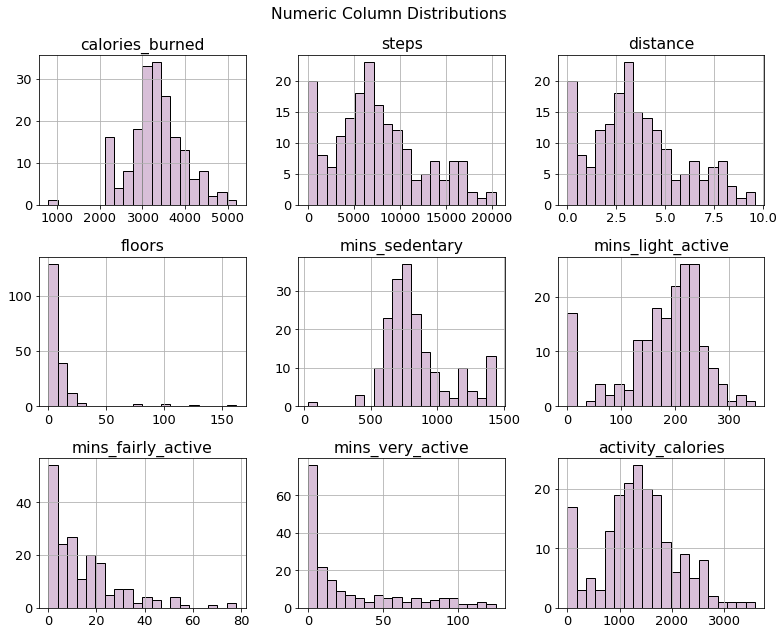

In [11]:
numeric_hists(train, bins=20)

***Observations***

1. (months)This individual appears to have worn a fitbit from the end of April to the begining o December

2. (activity_calories) This indidivudal burned around 1,500 cal per day, however it appars that they were unable or unwilling to exercise about 15 days during this time period

3. (distance) This individual walked on averge 3.5 miles a day,( about 7,000 steps)

4. (mins_sedentary) This individual spend most of the day sedientary (700 min or 12 hours), and if active engaged in light activity.

5. (floors) This individual spent the majority of their time walking up two flight of stairs daily.  

***

***Claims***

- Based on the evidence above I believe that the individual with this fit bit is a staff member.  The lack o food information and regular exercise suggest they are not members of the research group.  The sedintary nature of the individual and 2 flight of stairs daily suggest an employee who is aware of health and fitness but who has prioritys that often pull them in other directions.  

In [12]:
# Explore Target Variable
y = train.calories_burned
y.head()

date
2018-04-26    2635.0
2018-04-27    3649.0
2018-04-28    3379.0
2018-04-29    2851.0
2018-04-30    2825.0
Name: calories_burned, dtype: float64

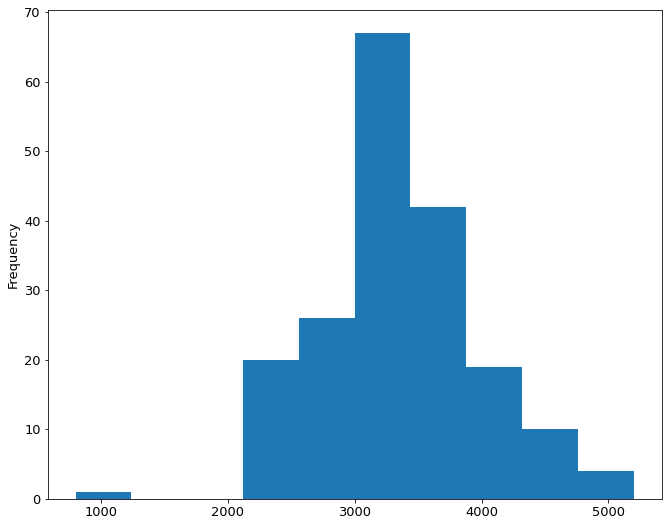

In [13]:
# Daily Trends
y.plot.hist()
plt.show()

***

`Individual appears to consistantly burn 3,300 calories a day (Suggestive of a female employee)`

***

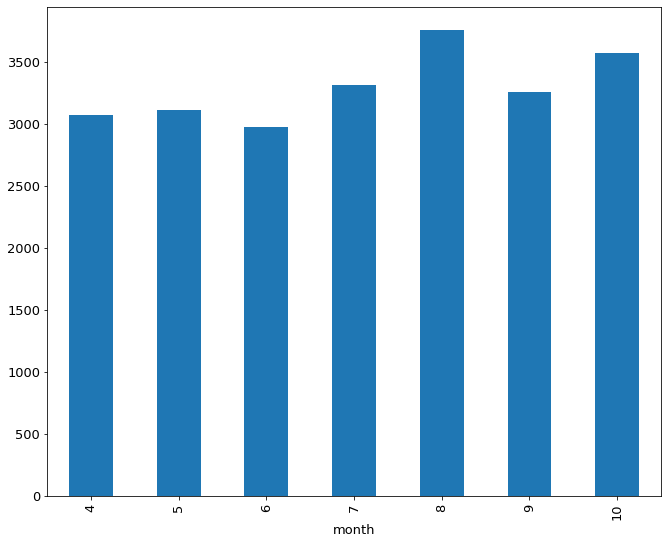

In [14]:
# Monthly Trends
train['month'] = train.index.month
train.groupby('month').calories_burned.mean().plot.bar()
plt.show()

***

`Individual appears to consistantly burn 3,200 calories a month, with more calories burned during month 7-10 (Most likely due to good weather`)


- Trend is increasing over time

- Seasonality is not observed, but infered as increase in activity in warmer months

***

### Visualize Weekly Seasonality

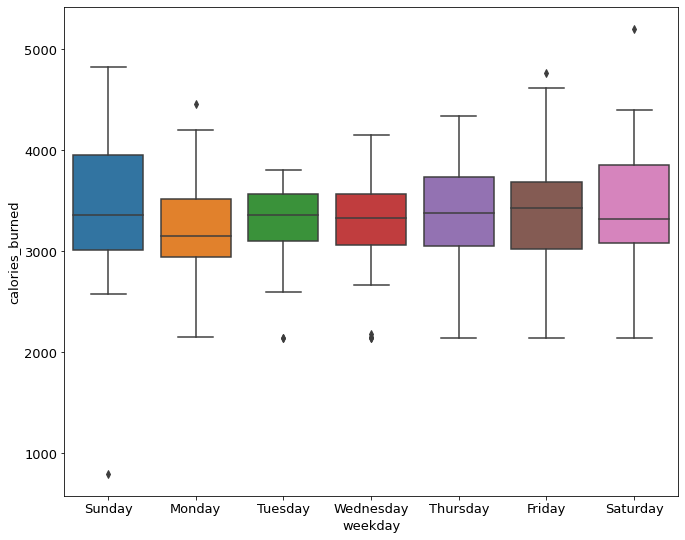

In [15]:
# Visualize Bins
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.boxplot(data = train, y='calories_burned', x='weekday', order=order)
plt.show()

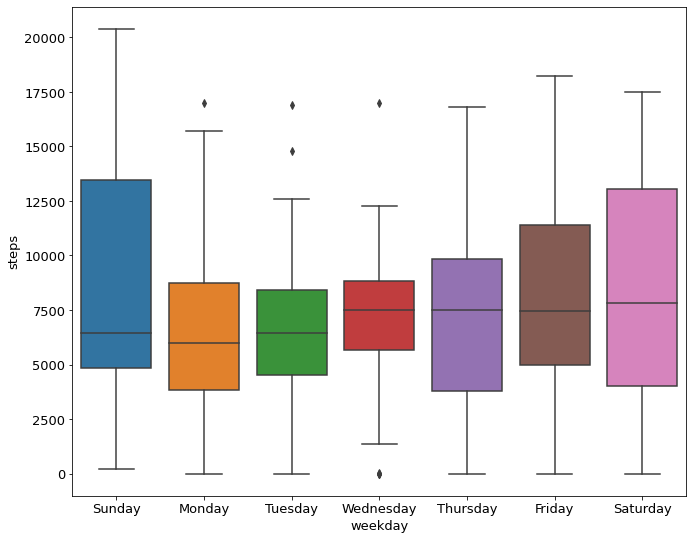

In [16]:
# Visualize Bins
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.boxplot(data = train, y='steps', x='weekday', order=order)
plt.show()

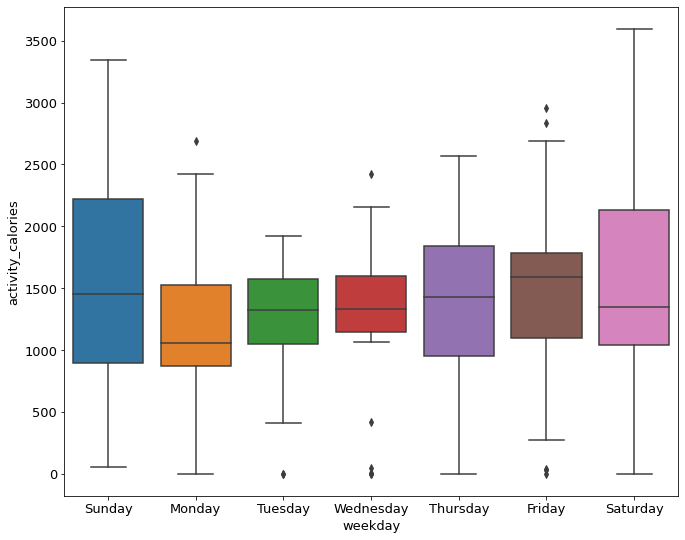

In [17]:
# Visualize Bins
order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
sns.boxplot(data = train, y='activity_calories', x='weekday', order=order)
plt.show()

### Visualize Montly Seasonality

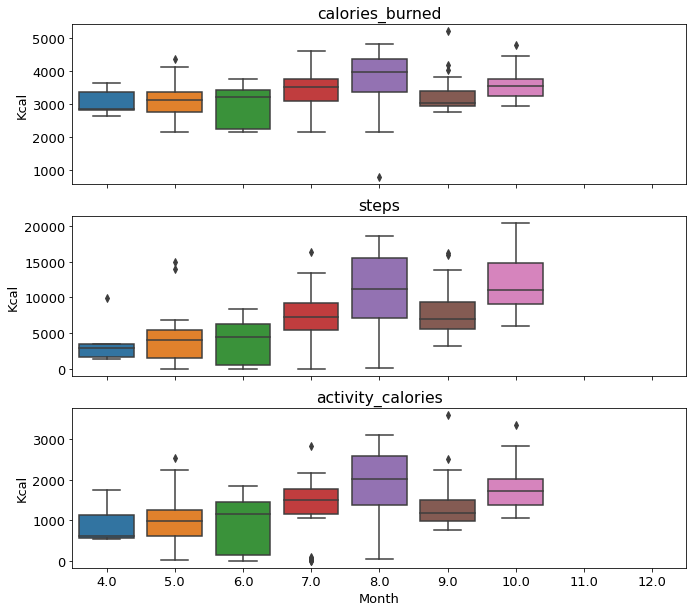

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)
for name, ax in zip(['calories_burned', 'steps', 'activity_calories'], axes):
    sns.boxplot(data=train, x='Month', y=name, ax=ax)
    ax.set_ylabel('Kcal')
    ax.set_title(name)
    # Remove the automatic x-axis label from all but the bottom subplot
    if ax != axes[-1]:
        ax.set_xlabel('')

### Exploring Seasonality

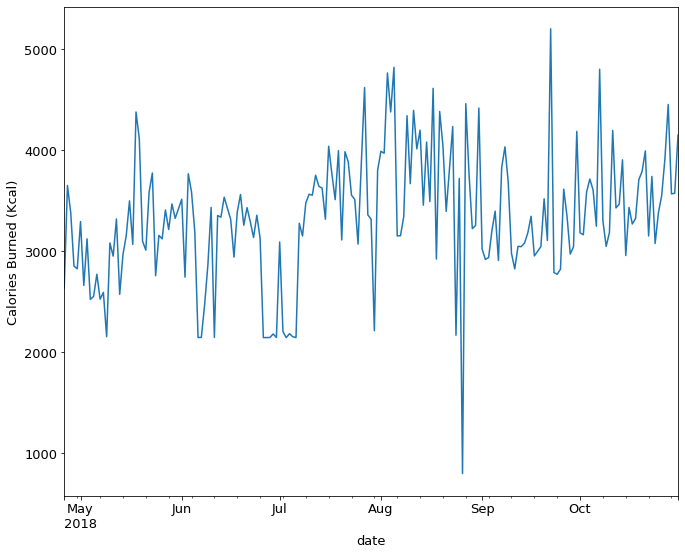

In [19]:
# Big Picture
ax = train.loc['2018','calories_burned'].plot()
ax.set_ylabel('Calories Burned (Kcal)');

***

`Now we can clearly see the weekly oscillations. Another interesting feature that becomes apparent at this level of granularity is the increase in calories burned between July-August`

***

#### Zoom in and explore 2 months (Aug -Sept)

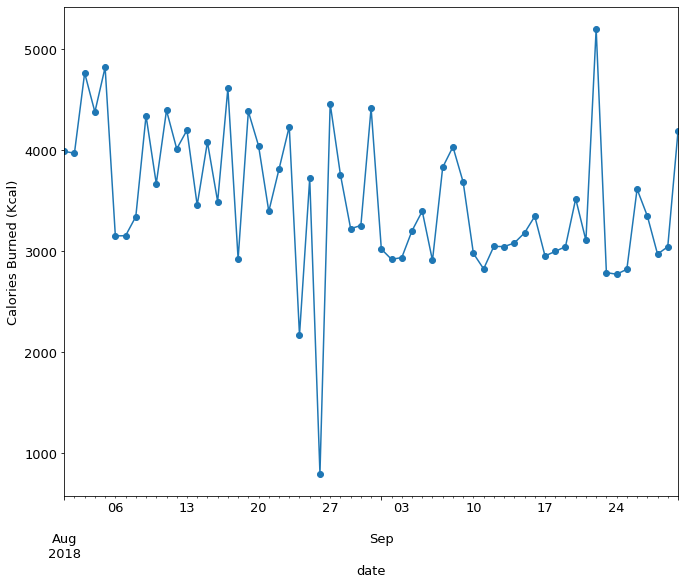

In [20]:
# Zoom in and explore 2 months (Aug -Sept)
ax = train.loc['2018-08':'2018-09', 'calories_burned'].plot(marker='o', linestyle='-')
ax.set_ylabel('Calories Burned (Kcal)');

***

`It appears calories burned is greatest on weekends and lowest on weekdays`

***

#### Zoom in to explore one week

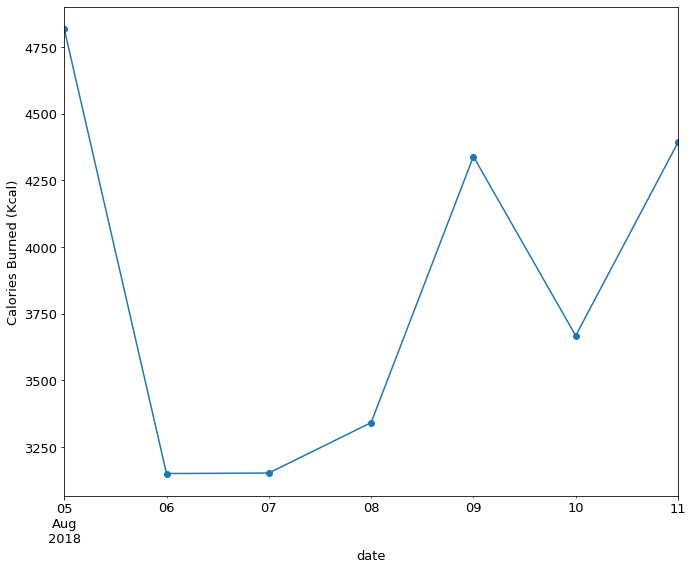

In [21]:
# Zoom in to explore one week

ax = train.loc['2018-08-05':'2018-08-11', 'calories_burned'].plot(marker='o', linestyle='-')
ax.set_ylabel('Calories Burned (Kcal)');

***

`It appears calories burned is greatest on weekends and lowest on weekdays`

***

#### Weekly Data Sorted by Mondays

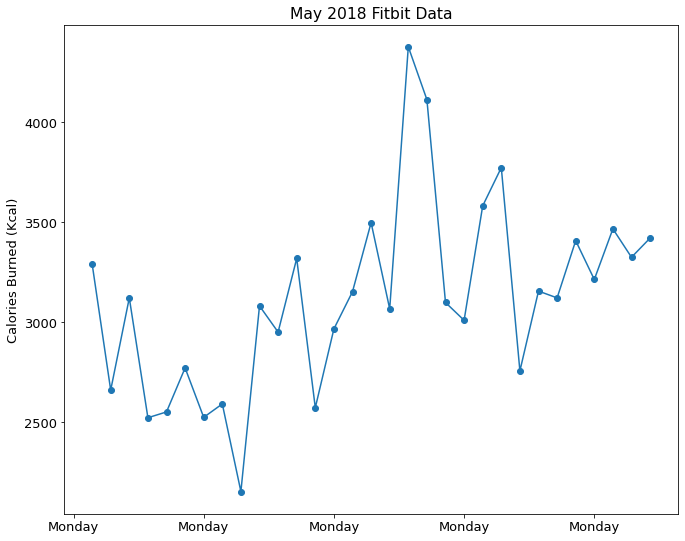

In [22]:
# What do weeks look like if they start on mondays?
fig, ax = plt.subplots()
ax.plot(train.loc['2018-05':'2018-05', 'calories_burned'], marker='o', linestyle='-')
ax.set_ylabel('Calories Burned (Kcal)')
ax.set_title('May 2018 Fitbit Data')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%A'));

#### Rolling Means

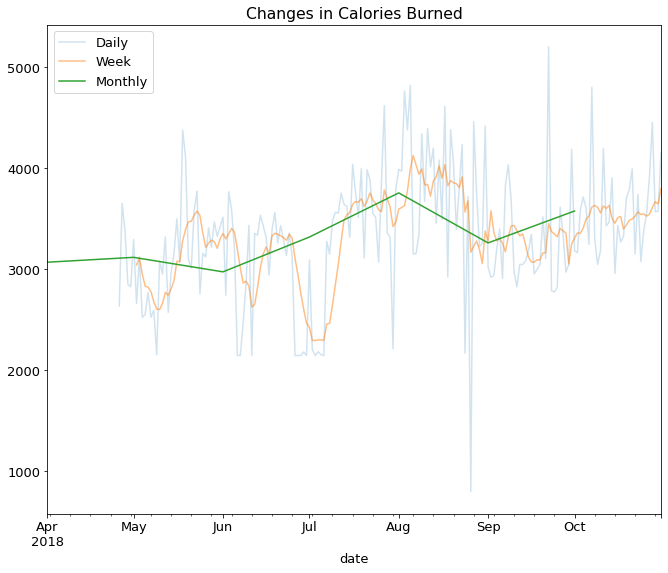

In [23]:
# Rolling Means
y = train.calories_burned
y.plot(alpha=.2, label='Daily')
y.resample('D').mean().rolling(7).mean().plot(alpha=.5, label='Week')
y.resample('M').mean().rolling(1).mean().plot(alpha=8, label='Monthly')
plt.legend()
plt.title('Changes in Calories Burned')
plt.show()


#### Seasonal Plot

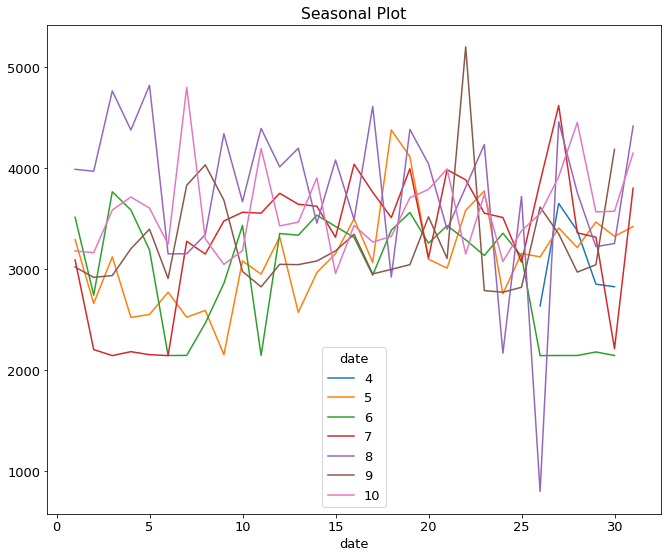

In [24]:
# .unstack turns an index level into columns
y = train.calories_burned
y.groupby([y.index.month, y.index.day]).mean().unstack(0).plot(title='Seasonal Plot')
plt.show()

#### Seasonal Sub Series Plot

In [25]:
y.groupby([y.index.month, y.index.day]).mean().unstack()

date,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
date,,,,,,,,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2635.0,3649.0,3379.0,2851.0,2825.0,NaN
5,3292.0,2660.0,3121.0,2522.0,2551.0,2771.0,2524.0,2591.0,2153.0,3081.0,...,3581.0,3772.0,2756.0,3155.0,3121.0,3407.0,3213.0,3466.0,3324.0,3420.0
6,3513.0,2742.0,3765.0,3585.0,3189.0,2145.0,2146.0,2465.0,2859.0,3432.0,...,3290.0,3134.0,3355.0,3127.0,2144.0,2145.0,2145.0,2180.0,2145.0,NaN
7,3090.0,2204.0,2144.0,2183.0,2153.0,2144.0,3275.0,3149.0,3476.0,3562.0,...,3883.0,3553.0,3510.0,3069.0,3864.0,4618.0,3358.0,3316.0,2212.0,3800.0
8,3987.0,3968.0,4762.0,4376.0,4818.0,3150.0,3152.0,3341.0,4339.0,3667.0,...,3811.0,4232.0,2168.0,3719.0,799.0,4458.0,3757.0,3222.0,3253.0,4415.0
9,3020.0,2918.0,2936.0,3201.0,3395.0,2907.0,3829.0,4031.0,3682.0,2977.0,...,5199.0,2787.0,2771.0,2820.0,3613.0,3348.0,2970.0,3043.0,4184.0,NaN
10,3180.0,3162.0,3584.0,3713.0,3603.0,3246.0,4799.0,3299.0,3046.0,3183.0,...,3149.0,3739.0,3075.0,3379.0,3549.0,3915.0,4450.0,3566.0,3572.0,4147.0


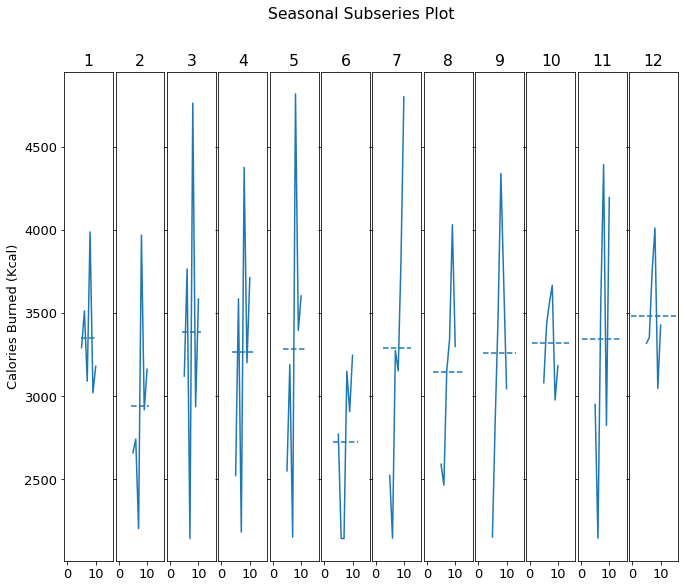

In [26]:
table = y.groupby([y.index.month, y.index.day]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True)
for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), ls='--')
    ax.set(xlabel='')

axs[0].set(ylabel='Calories Burned (Kcal)')
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
fig.subplots_adjust(wspace=.05)

#### Lag Plot (Day by Day)

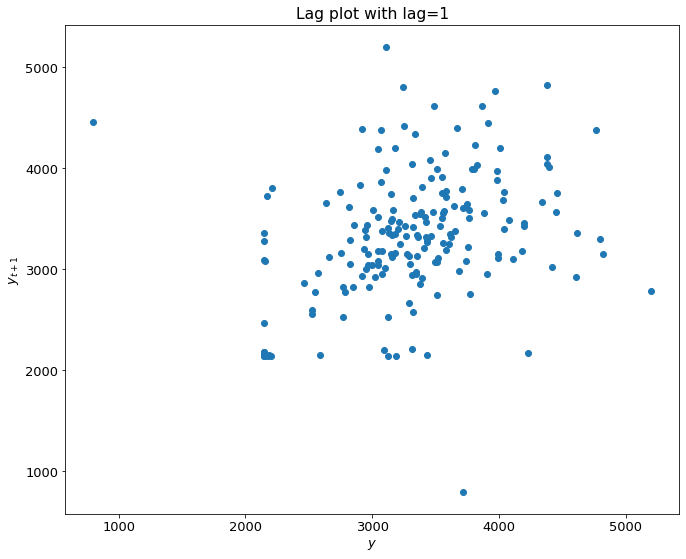

In [27]:
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')
plt.show()

***

`Not a great correlation, one day does not really predict the following`

***

#### Lag Plot (Week by Week)

,this_week,the_next_week
date,,
2018-04-29,3128.500000,2820.285714
2018-05-06,2820.285714,2741.285714
2018-05-13,2741.285714,3466.714286
2018-05-20,3466.714286,3257.285714
2018-05-27,3257.285714,3349.000000
2018-06-03,3349.000000,2831.571429
2018-06-10,2831.571429,3148.714286
2018-06-17,3148.714286,3344.285714
2018-06-24,3344.285714,2425.142857


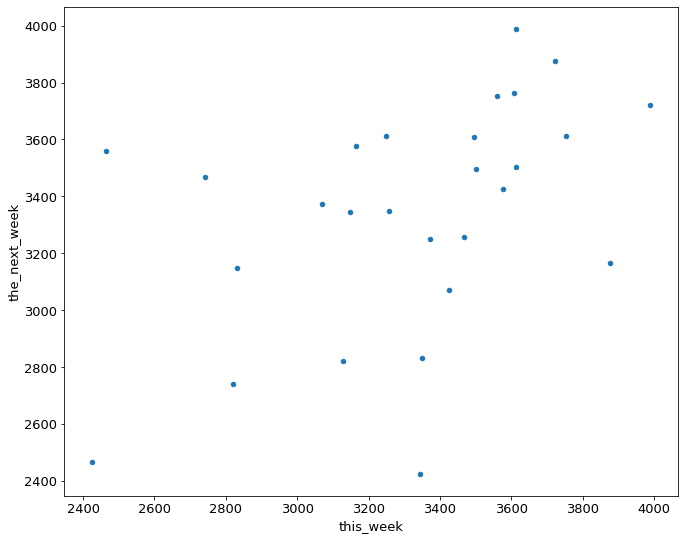

In [28]:
y = pd.DataFrame(train.calories_burned)
weekly = y.resample('W').mean()
weekly['the_next_week'] = weekly.calories_burned.shift(-1)
weekly = weekly.rename(columns={'calories_burned': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

***

`Not a great correlation, one month does not really predict the following`

***

#### Lag Plot (Month to Month)

,this_month,the_next_month
date,,
2018-04-29,3128.500000,3257.285714
2018-05-06,2820.285714,3349.000000
2018-05-13,2741.285714,2831.571429
2018-05-20,3466.714286,3148.714286
2018-05-27,3257.285714,3344.285714
2018-06-03,3349.000000,2425.142857
2018-06-10,2831.571429,2464.571429
2018-06-17,3148.714286,3559.857143
2018-06-24,3344.285714,3753.571429


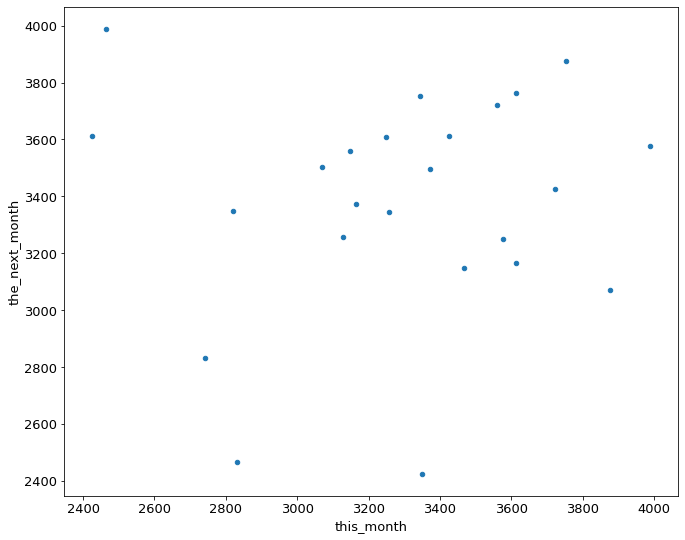

In [29]:
y = pd.DataFrame(train.calories_burned)
weekly = y.resample('W').mean()
weekly['the_next_month'] = weekly.calories_burned.shift(-4)
weekly = weekly.rename(columns={'calories_burned': 'this_month'})
weekly.plot.scatter(x='this_month', y='the_next_month')
weekly

#### Autocorrelation Plot: Is there any Correlation?

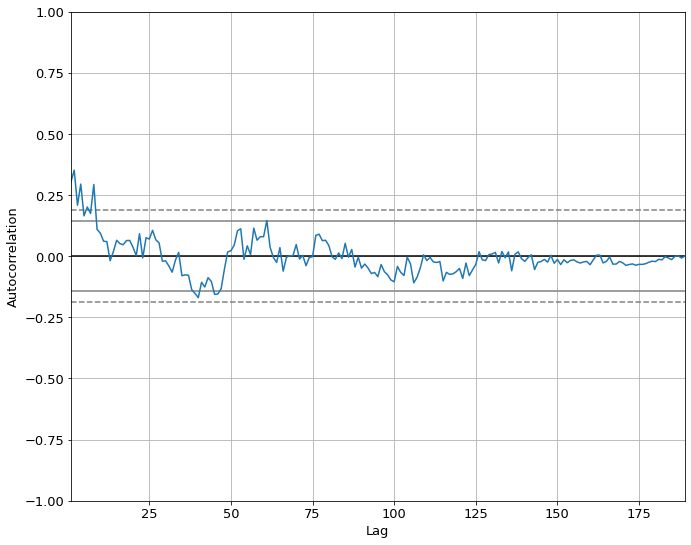

In [30]:
pd.plotting.autocorrelation_plot(train.calories_burned.resample('D').mean())
plt.show()

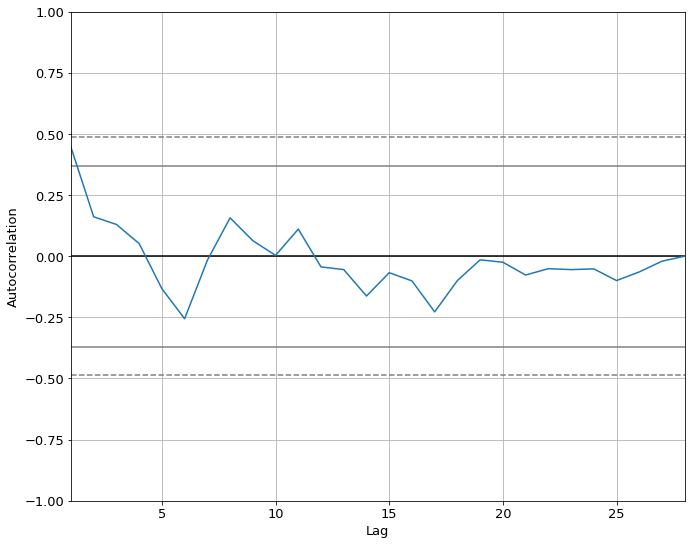

In [31]:
pd.plotting.autocorrelation_plot(train.calories_burned.resample('W').mean())
plt.show()

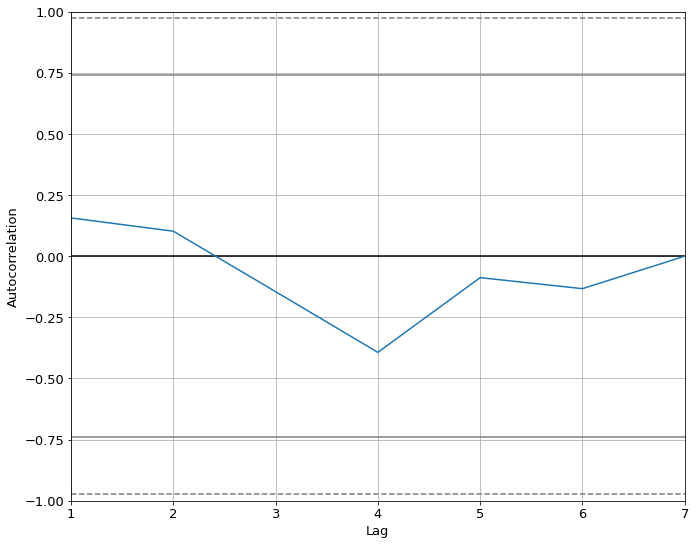

In [32]:
pd.plotting.autocorrelation_plot(train.calories_burned.resample('M').mean())
plt.show()

***

`Slight correlation day by day, but correlation becomes insignificant after 7 days`

***

***

## Maybe Another Feature is the way to go?

***

### Steps?

#### Lag Plot: (Steps Day to Day)

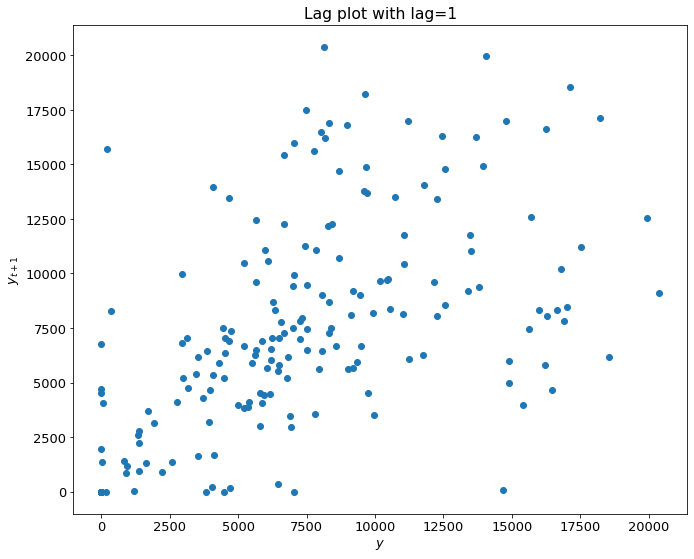

In [33]:
y = pd.DataFrame(train.steps)
plt.scatter(y, y.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')
plt.show()

### Lag Time: Weekly

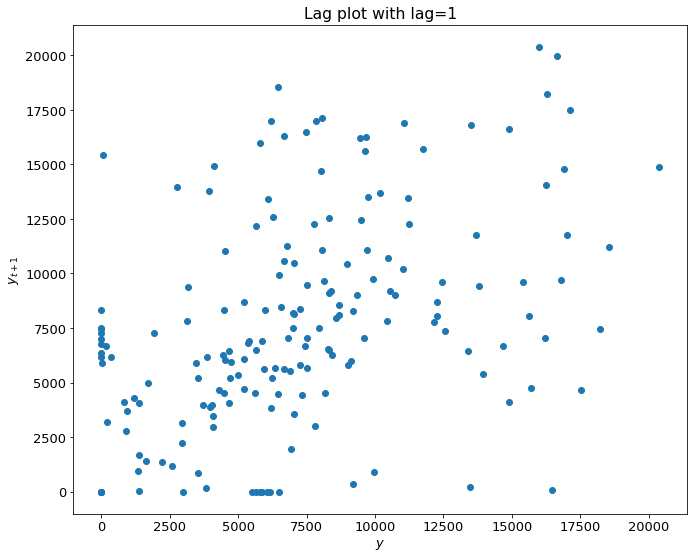

In [34]:
y = pd.DataFrame(train.steps)
plt.scatter(y, y.shift(-7))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')
plt.show()

***

`Already better correlation then calories burned`

***

#### Autocorrelation Plot: Steps

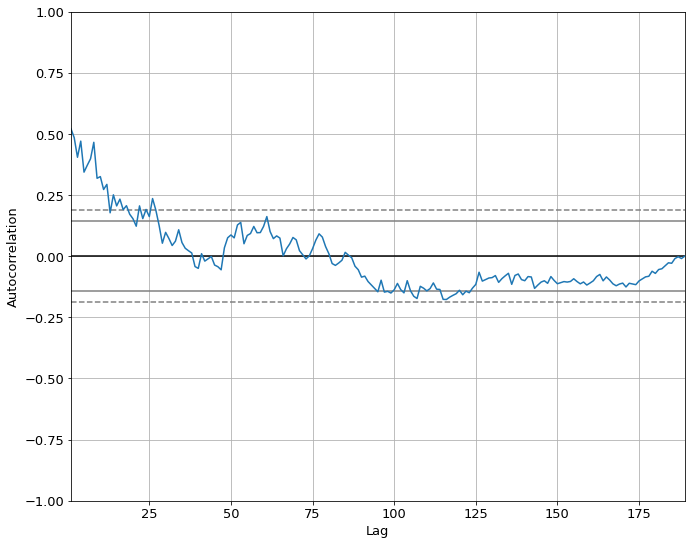

In [35]:
pd.plotting.autocorrelation_plot(train.steps.resample('D').mean())
plt.show()

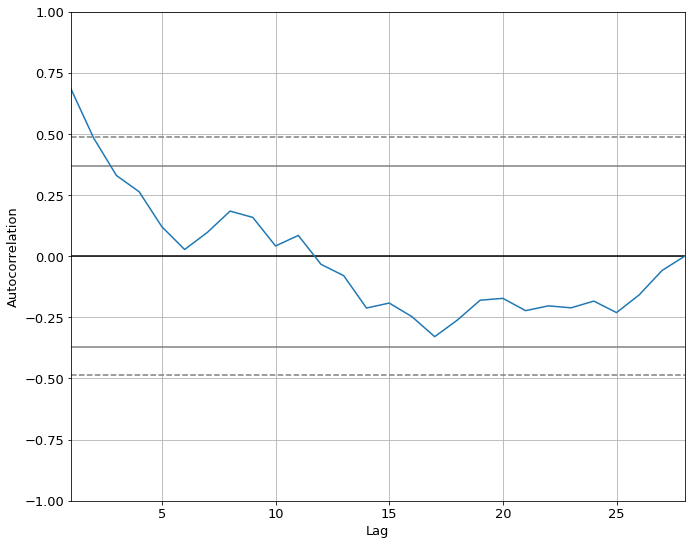

In [36]:
pd.plotting.autocorrelation_plot(train.steps.resample('W').mean())
plt.show()

***

`Better correlation then calories burned, probably a better feature to use for modeling`

***

#### One Last Sanity Check before Moving Forward with Modeling

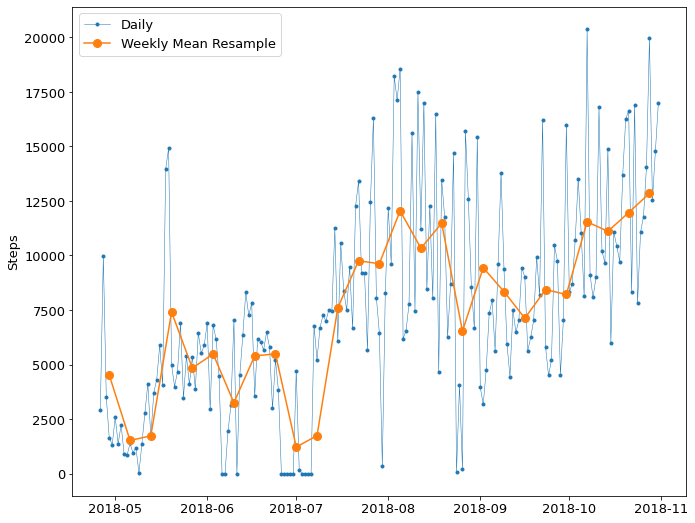

In [37]:
data_columns = ['steps']
opsd_weekly_mean = train[data_columns].resample('W').mean()
# Start and end of the date range to extract
start, end = '2018-04', '2018-10'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(train.loc[start:end, 'steps'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(opsd_weekly_mean.loc[start:end, 'steps'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.set_ylabel('Steps')
ax.legend();